# Mapillary label analysis

This notebook aims at describing the [Mapillary](https://www.mapillary.com/dataset/vistas) dataset. This dataset is used for semantic segmentation purpose, and contains 25000 street-scene images:
- 18000 in training dataset;
- 2000 in validation dataset;
- 5000 in testing dataset.

In the following cells, the dataset labels will be described, and their popularity within dataset will be evaluated. Additionnally, the following questions will be answered: what is the frequency of appearance of each object type? How many labels appear on a typical image? What are the most frequent object association?

## Introduction

As usual, we import the useful module. `pandas` is of course needed, as we will handle dataframes.

In [1]:
import itertools
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

%matplotlib inline

Some modules in `./deeposlandia` are recovered to make the analysis easier.

In [2]:
env DEEPOSL_CONFIG=../config.ini

env: DEEPOSL_CONFIG=../config.ini


In [3]:
from deeposlandia import utils, aggregate_label
from deeposlandia.datasets import mapillary

In [4]:
DATAPATH = '../data'
DATASET = 'mapillary'

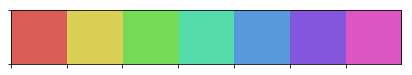

In [5]:
palette = sns.color_palette('hls', 7)
sns.palplot(palette)

## Metadata description

In the following paragraphs, we describe an aggregated version of the original Mapillary dataset. This aggregation has been hand-made, and every subsequent results depends on it. This classification is inspired from original label families.

In [6]:
config = utils.read_config(os.path.join(DATAPATH, DATASET, "input", "config_aggregate.json"))

In [7]:
labels = config["labels"]
labels[:2]

[{'id': 0,
  'family': 'animal',
  'name': 'animal',
  'contains': 'bird...ground-animal',
  'contains_id': [0, 1],
  'color': [229, 85, 76],
  'evaluate': True},
 {'id': 1,
  'family': 'construction',
  'name': 'barrier',
  'contains': 'curb...fence...guard-rail...other-barrier...wall',
  'contains_id': [2, 3, 4, 5, 6],
  'color': [229, 156, 76],
  'evaluate': True}]

In order to describe the Mapillary dataset labels, we transform the information contained into configuration file as a `pandas.DataFrame`.

In [8]:
df_labels = pd.DataFrame(labels)
df_labels.head(3)

,color,contains,contains_id,evaluate,family,id,name
0,"[229, 85, 76]",bird...ground-animal,"[0, 1]",True,animal,0,animal
1,"[229, 156, 76]",curb...fence...guard-rail...other-barrier...wall,"[2, 3, 4, 5, 6]",True,construction,1,barrier
2,"[229, 226, 76]",bike-lane...crosswalk-plain...curb-cut...parki...,"[7, 8, 9, 10, 11, 12, 13, 14, 15]",True,construction,2,flat


In [9]:
len(df_labels)

13

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
 <a list of 13 Text xticklabel objects>)

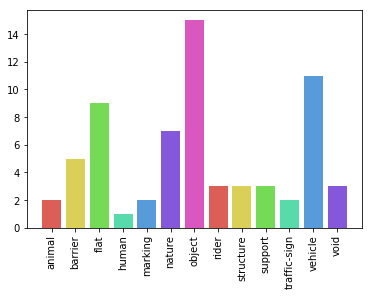

In [10]:
label_categories = df_labels['name'].unique()
plt.bar(df_labels['name'], df_labels["contains_id"].apply(len), color=palette)
plt.xticks(rotation=90)

These aggregation step makes a balanced distribution. In particular, we denote:
- 16 miscellaneous `object` labels:

In [11]:
df_labels.loc[df_labels['name']=="object", "contains"].values[0].split("...")

['banner',
 'bench',
 'bike-rack',
 'billboard',
 'catch-basin',
 'cctv-camera',
 'fire-hydrant',
 'junction-box',
 'mailbox',
 'manhole',
 'phone-booth',
 'pothole',
 'street-light',
 'traffic-light',
 'trash-can']

- 11 `vehicle` objects:

In [12]:
df_labels.loc[df_labels['name']=="vehicle", "contains"].values[0].split("...")

['bicycle',
 'boat',
 'bus',
 'car',
 'caravan',
 'motorcycle',
 'on-rails',
 'other-vehicle',
 'trailer',
 'truck',
 'wheeled-slow']

- 9 `flat` objects:

In [13]:
df_labels.loc[df_labels['name']=="flat", "contains"].values[0].split("...")

['bike-lane',
 'crosswalk-plain',
 'curb-cut',
 'parking',
 'pedestrian-area',
 'rail-track',
 'road',
 'service-lane',
 'sidewalk']

- and so on...

## Data description

In order to describe the dataset itself, we focus on preprocessed images of size `400 * 400`. We directly consider aggregated datasets.

In [14]:
config = utils.read_config(os.path.join(DATAPATH, DATASET, 'preprocessed', '400', 'training.json'))

The configuration file for preprocessed dataset contains a `images` section, where the presence of every label is filled in. By extracting this information and transforming it into a `pandas.DataFrame` (each row refers to an image, each column to a label, a ̀`1` means that the label is on the picture), we can show the first images as an example:

In [19]:
label_popularity = [image['labels'] for image in config['images']]
label_popularity = pd.DataFrame(label_popularity)
label_popularity.head(3)

,0,1,10,11,12,2,3,4,5,6,7,8,9
0,1,1,1,1,1,1,1,1,1,1,0,1,1
1,0,1,1,1,1,1,1,1,1,1,1,1,1
2,0,1,1,1,1,1,1,1,1,1,0,1,1


By simple `apply` calls, we can get the number of available objects per image, as well as the number of images in which each label is available.

In [16]:
image_count_per_label = label_popularity.apply(sum, axis=0)

In [17]:
image_count_per_label = label_popularity.apply(sum, axis=0)
image_count_per_label.index = image_count_per_label.index.astype(int)
print("The label '{}' is on {} images.".format(df_labels.loc[0, "name"], image_count_per_label[0]))
label_count_per_image = label_popularity.apply(sum, axis=1)
print("The image {} contains {} labels.".format(0, label_count_per_image[0]))

The label 'animal' is on 773 images.
The image 0 contains 12 labels.


As examples, we learn here that 773 images contain animals in the this preprocessed training dataset. And that the first image contains every aggregated labels (there are 12).

To generalize the point, we can detail these features and plot them as histograms.

In [20]:
print("Number of images per label:\n{}".format(image_count_per_label.describe().astype(int)))

Number of images per label:
count       13
mean     14214
std       5984
min        773
25%      16159
50%      17050
75%      17625
max      17943
dtype: int64


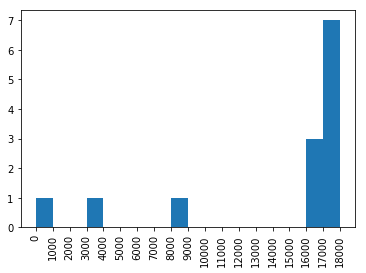

In [24]:
image_count_hist = plt.hist(image_count_per_label,
                            bins=range(0, 18001, 1000))
xt = plt.xticks(range(0, 18001, 1000), rotation=90)

Almost every label are in a large majority of images. There is only two labels that look rare.

In [25]:
print("Number of labels per image:\n{}".format(label_count_per_image.describe().astype(int)))

Number of labels per image:
count    18000
mean        10
std          1
min          1
25%         10
50%         10
75%         11
max         13
dtype: int64


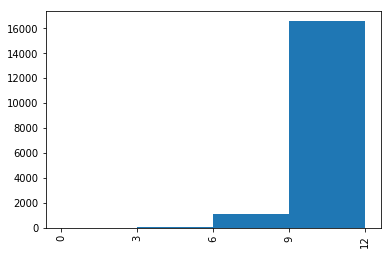

In [26]:
label_count_hist = plt.hist(label_count_per_image,
                            bins=range(0, 13, 3))
xt = plt.xticks(range(0, 13, 3), rotation=90)

On the other hand, one may see that a majority of images contains more than 9 labels (over 12).

In [27]:
df_labels['nb_images'] = image_count_per_label

In [28]:
df_labels

,color,contains,contains_id,evaluate,family,id,name,nb_images
0,"[229, 85, 76]",bird...ground-animal,"[0, 1]",True,animal,0,animal,773
1,"[229, 156, 76]",curb...fence...guard-rail...other-barrier...wall,"[2, 3, 4, 5, 6]",True,construction,1,barrier,17484
2,"[229, 226, 76]",bike-lane...crosswalk-plain...curb-cut...parki...,"[7, 8, 9, 10, 11, 12, 13, 14, 15]",True,construction,2,flat,17929
3,"[161, 229, 76]",person,[19],True,human,3,human,8475
4,"[90, 229, 76]",crosswalk-zebra...general,"[23, 24]",True,marking,4,marking,16159
5,"[76, 229, 132]",mountain...sand...sky...snow...terrain...veget...,"[25, 26, 27, 28, 29, 30, 31]",True,nature,5,nature,17943
6,"[76, 229, 203]",banner...bench...bike-rack...billboard...catch...,"[32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 4...",True,object,6,object,17140
7,"[76, 185, 229]",bicyclist...motorcyclist...other-rider,"[20, 21, 22]",True,human,7,rider,3200
8,"[76, 114, 229]",bridge...building...tunnel,"[16, 17, 18]",True,construction,8,structure,16701
9,"[109, 76, 229]",pole...traffic-sign-frame...utility-pole,"[45, 46, 47]",True,object,9,support,17826


The most frequent labels are landscape items (`nature`, *i.e.* sky or vegetation), `flat` items (*i.e.* roads) or `support` (poles, mainly), which seems trivial for street-scene images.

In [29]:
df_labels.sort_values("nb_images", ascending=False)[['name', 'nb_images']].head(3)

,name,nb_images
5,nature,17943
2,flat,17929
9,support,17826


On the other hand, rare objects within the dataset are mostly living beings like `animal`, `rider` or `human` (pedestrians).

In [31]:
df_labels.sort_values("nb_images", ascending=True)[['name', 'nb_images']].head(3)

,name,nb_images
0,animal,773
7,rider,3200
3,human,8475
